# 🧠 ResNet50 Image Classifier with Albumentations on Kaggle
This notebook performs classification using:
- `Albumentations` for strong augmentations
- `ResNet50` pretrained backbone
- `ImageFolder`-based `DataLoader`
- Evaluation: Accuracy, Precision, Recall

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from albumentations.pytorch import ToTensorV2
import albumentations as A
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import os
import random
import shutil

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
import random

SOURCE_DIR = '/kaggle/input/new-dataset-football-classification/New folder'
DEST_DIR = '/kaggle/working/split_dataset'
SPLIT_RATIOS = [0.7, 0.15, 0.15]
random.seed(42)

# Create split folders
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(SOURCE_DIR):
        os.makedirs(os.path.join(DEST_DIR, split, class_name), exist_ok=True)

for class_name in os.listdir(SOURCE_DIR):
    full_path = os.path.join(SOURCE_DIR, class_name)
    if not os.path.isdir(full_path): continue
    images = os.listdir(full_path)
    random.shuffle(images)
    total = len(images)
    t1, t2 = int(SPLIT_RATIOS[0]*total), int((SPLIT_RATIOS[0]+SPLIT_RATIOS[1])*total)
    splits = {'train': images[:t1], 'val': images[t1:t2], 'test': images[t2:]}
    for split, files in splits.items():
        for f in files:
            shutil.copy(os.path.join(full_path, f), os.path.join(DEST_DIR, split, class_name, f))

In [3]:

from torch.utils.data import Dataset, DataLoader
train_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.Blur(blur_limit=3, p=0.3),
    A.ColorJitter(p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_test_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = ImageFolder(root=root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_path, label = self.dataset.samples[idx]
        image = np.array(Image.open(img_path).convert('RGB'))
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label

In [4]:
train_data = CustomDataset('/kaggle/working/split_dataset/train', transform=train_transforms)
val_data = CustomDataset('/kaggle/working/split_dataset/val', transform=val_test_transforms)
test_data = CustomDataset('/kaggle/working/split_dataset/test', transform=val_test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

num_classes = len(train_data.dataset.classes)

In [5]:
# 🧠 Model definition
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)
model.to(device)

# ⚙️ Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

# ⏹️ Early stopping setup
best_val_loss = float('inf')
patience = 3
patience_counter = 0

# 🚀 Training + Validation loop
for epoch in range(20):
    model.train()
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss, preds, targets = 0, [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, 1)
            preds.extend(pred.cpu())
            targets.extend(labels.cpu())

    from sklearn.metrics import accuracy_score, precision_score, recall_score
    acc = accuracy_score(targets, preds)
    prec = precision_score(targets, preds, average='macro')
    rec = recall_score(targets, preds, average='macro')
    print(f"Epoch {epoch+1}: val_loss={val_loss:.4f}, acc={acc:.4f}, precision={prec:.4f}, recall={rec:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), '/kaggle/working/best_model.pth')
        print("✅ New best model saved.")
    else:
        patience_counter += 1
        print(f"🕒 No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


Epoch 1: val_loss=12.8209, acc=0.8529, precision=0.8659, recall=0.8473
✅ New best model saved.
Epoch 2: val_loss=8.0814, acc=0.8735, precision=0.8744, recall=0.8794
✅ New best model saved.
Epoch 3: val_loss=5.9968, acc=0.8971, precision=0.8950, recall=0.9017
✅ New best model saved.
Epoch 4: val_loss=5.0090, acc=0.8971, precision=0.8966, recall=0.8978
✅ New best model saved.
Epoch 5: val_loss=4.4746, acc=0.9029, precision=0.9008, recall=0.9048
✅ New best model saved.
Epoch 6: val_loss=4.0291, acc=0.9059, precision=0.9053, recall=0.9050
✅ New best model saved.
Epoch 7: val_loss=3.9017, acc=0.9088, precision=0.9045, recall=0.9151
✅ New best model saved.
Epoch 8: val_loss=3.6766, acc=0.9059, precision=0.9039, recall=0.9086
✅ New best model saved.
Epoch 9: val_loss=3.5183, acc=0.9088, precision=0.9061, recall=0.9125
✅ New best model saved.
Epoch 10: val_loss=3.5415, acc=0.9029, precision=0.8990, recall=0.9085
🕒 No improvement. Patience: 1/3
Epoch 11: val_loss=3.2205, acc=0.9059, precision=0

In [6]:
best_val_loss = float('inf')
for epoch in range(20):
    model.train()
    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss, preds, targets = 0, [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, 1)
            preds.extend(pred.cpu())
            targets.extend(labels.cpu())

    acc = accuracy_score(targets, preds)
    prec = precision_score(targets, preds, average='macro')
    rec = recall_score(targets, preds, average='macro')
    print(f"Epoch {epoch+1}: val_loss={val_loss:.4f}, acc={acc:.4f}, precision={prec:.4f}, recall={rec:.4f}")
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

100%|██████████| 50/50 [00:09<00:00,  5.50it/s]


Epoch 1: val_loss=2.7847, acc=0.9176, precision=0.9155, recall=0.9189


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


Epoch 2: val_loss=2.8053, acc=0.9147, precision=0.9107, recall=0.9157


100%|██████████| 50/50 [00:09<00:00,  5.32it/s]


Epoch 3: val_loss=2.7878, acc=0.9147, precision=0.9125, recall=0.9157


100%|██████████| 50/50 [00:09<00:00,  5.25it/s]


Epoch 4: val_loss=2.7770, acc=0.9176, precision=0.9146, recall=0.9198


100%|██████████| 50/50 [00:09<00:00,  5.47it/s]


Epoch 5: val_loss=2.7650, acc=0.9206, precision=0.9179, recall=0.9213


100%|██████████| 50/50 [00:09<00:00,  5.31it/s]


Epoch 6: val_loss=2.7204, acc=0.9206, precision=0.9170, recall=0.9229


100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


Epoch 7: val_loss=2.7736, acc=0.9147, precision=0.9130, recall=0.9148


100%|██████████| 50/50 [00:09<00:00,  5.44it/s]


Epoch 8: val_loss=2.7574, acc=0.9206, precision=0.9188, recall=0.9209


100%|██████████| 50/50 [00:09<00:00,  5.48it/s]


Epoch 9: val_loss=2.6766, acc=0.9265, precision=0.9260, recall=0.9281


100%|██████████| 50/50 [00:09<00:00,  5.26it/s]


Epoch 10: val_loss=2.7654, acc=0.9176, precision=0.9154, recall=0.9178


100%|██████████| 50/50 [00:09<00:00,  5.27it/s]


Epoch 11: val_loss=2.7352, acc=0.9176, precision=0.9163, recall=0.9183


100%|██████████| 50/50 [00:09<00:00,  5.29it/s]


Epoch 12: val_loss=2.7159, acc=0.9206, precision=0.9179, recall=0.9213


100%|██████████| 50/50 [00:09<00:00,  5.40it/s]


Epoch 13: val_loss=2.8330, acc=0.9206, precision=0.9193, recall=0.9220


100%|██████████| 50/50 [00:08<00:00,  5.56it/s]


Epoch 14: val_loss=2.7044, acc=0.9118, precision=0.9087, recall=0.9122


100%|██████████| 50/50 [00:09<00:00,  5.34it/s]


Epoch 15: val_loss=2.7534, acc=0.9206, precision=0.9178, recall=0.9183


100%|██████████| 50/50 [00:09<00:00,  5.37it/s]


Epoch 16: val_loss=2.7501, acc=0.9206, precision=0.9192, recall=0.9200


100%|██████████| 50/50 [00:09<00:00,  5.31it/s]


Epoch 17: val_loss=2.7191, acc=0.9206, precision=0.9193, recall=0.9220


100%|██████████| 50/50 [00:09<00:00,  5.16it/s]


Epoch 18: val_loss=2.6746, acc=0.9206, precision=0.9179, recall=0.9224


100%|██████████| 50/50 [00:09<00:00,  5.38it/s]


Epoch 19: val_loss=2.7076, acc=0.9235, precision=0.9213, recall=0.9254


100%|██████████| 50/50 [00:09<00:00,  5.53it/s]


Epoch 20: val_loss=2.6647, acc=0.9294, precision=0.9282, recall=0.9306


In [7]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        pred = torch.argmax(outputs, 1)
        test_preds.extend(pred.cpu())
        test_labels.extend(labels.cpu())

acc = accuracy_score(test_labels, test_preds)
prec = precision_score(test_labels, test_preds, average='macro')
rec = recall_score(test_labels, test_preds, average='macro')
print(f"✅ Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f}")

/tmp/ipykernel_31/341848418.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


✅ Test Accuracy: 0.9273 | Precision: 0.9278 | Recall: 0.9337


In [8]:
import zipfile

with zipfile.ZipFile('/kaggle/working/best_model.zip', 'w') as zipf:
    zipf.write('/kaggle/working/best_model.pth', arcname='best_model.pth')


In [9]:
test_preds = []
test_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu())
        test_labels.extend(labels.cpu())


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

acc = accuracy_score(test_labels, test_preds)
prec = precision_score(test_labels, test_preds, average='macro')
rec = recall_score(test_labels, test_preds, average='macro')

print(f"✅ Test Accuracy:  {acc:.4f}")
print(f"✅ Test Precision: {prec:.4f}")
print(f"✅ Test Recall:    {rec:.4f}")


✅ Test Accuracy:  0.9273
✅ Test Precision: 0.9278
✅ Test Recall:    0.9337


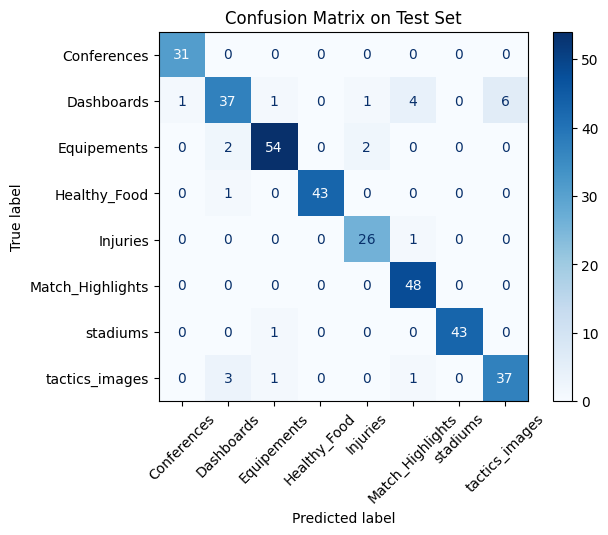

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, test_preds, display_labels=test_data.dataset.classes, xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix on Test Set")
plt.show()


In [13]:
# --- Evaluate on test set ---
model.eval()

y_pred = []
true_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        y_pred.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# --- Generate and print classification report ---
from sklearn.metrics import classification_report

report = classification_report(
    true_labels,
    y_pred,
    target_names=test_data.dataset.classes,
    digits=4
)

print("📋 Final Evaluation Report on Test Set:")
print(report)


📋 Final Evaluation Report on Test Set:
                  precision    recall  f1-score   support

     Conferences     0.9688    1.0000    0.9841        31
      Dashboards     0.8605    0.7400    0.7957        50
     Equipements     0.9474    0.9310    0.9391        58
    Healthy_Food     1.0000    0.9773    0.9885        44
        Injuries     0.8966    0.9630    0.9286        27
Match_Highlights     0.8889    1.0000    0.9412        48
        stadiums     1.0000    0.9773    0.9885        44
  tactics_images     0.8605    0.8810    0.8706        42

        accuracy                         0.9273       344
       macro avg     0.9278    0.9337    0.9295       344
    weighted avg     0.9274    0.9273    0.9261       344

